# Predicting Heart Disease in the Cleveland Dataset: The Role of Age, Cholesterol, and Maximum Heart Rate

## Introduction

Heart disease is the leading cause of death worldwide, making early detection and management crucial. Predictive modeling using clinical and demographic data can help identify individuals at risk. In this project, I aim to examine whether age, cholesterol levels, and maximum heart rate achieved can predict the presence of heart disease using the Cleveland dataset, a part of the UCI Heart Disease dataset. This dataset comprises clinical measurements from patients assessed for heart disease, including demographics, blood pressure, cholesterol levels, and heart function metrics.

My research question is: "Can age, cholesterol levels, and maximum heart rate achieved predict the presence of heart disease in the Cleveland dataset?" By addressing this, I hope to enhance the understanding and prediction of heart disease, contributing to better preventive measures in healthcare.

In [4]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source('cleanup.R')


Attaching package: ‘testthat’


The following object is masked from ‘package:rsample’:

    matches


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches



Attaching package: ‘rlang’


The following objects are masked from ‘package:testthat’:

    is_false, is_null, is_true


The following objects are masked from ‘package:purrr’:

    %@%, flatten, flatten_chr, flatten_dbl, flatten_int, flatten_lgl,
    flatten_raw, invoke, splice




## Reading The Data:

In [9]:
cleveland_data <- read_csv("data/heart_disease/processed.cleveland.data")

New names:
• `1.0` -> `1.0...2`
• `1.0` -> `1.0...3`
• `1.0` -> `1.0...6`
• `0.0` -> `0.0...9`
• `0.0` -> `0.0...12`
Rows: 302 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Cleaning and Wrangling Data:

In [10]:
colnames(cleveland_data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", 
                              "cs", "thal", "num")
cleveland_data <- cleveland_data |>
                  mutate(age = as.numeric(age),
                         chol = as.numeric(chol),
                         thalach = as.numeric(thalach),
                         exang = as.factor(exang),
                         num = as.factor(num))
cleveland_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,cs,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<fct>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


## Summarizing the Data:

In [14]:
summary_table <- cleveland_data |>
                  summarize(
                    count = n(),
                    average_age = mean(age, na.rm = TRUE),
                    average_cholesterol = mean(chol, na.rm = TRUE),
                    average_max_heart_rate = mean(thalach, na.rm = TRUE),
                    heart_disease_presence = sum(num == 1, na.rm = TRUE),
                    missing_data = sum(is.na(age) | is.na(chol) | is.na(thalach))
                  )
summary_table

count,average_age,average_cholesterol,average_max_heart_rate,heart_disease_presence,missing_data
<int>,<dbl>,<dbl>,<dbl>,<int>,<int>
302,54.4106,246.7384,149.606,55,0


The summary table from the Cleveland dataset presents a comprehensive view of key clinical metrics that are instrumental for predictive analysis in cardiovascular health. The dataset comprises 302 patient records, each meticulously recorded without any missing data for the critical variables under consideration. This completeness is vital for the integrity of the analysis.

**Summary Table Content:**

- **Count**: The dataset contains 302 observations, confirming a sufficient sample size for analysis.
- **Average Age**: The mean age of participants is 54.41 years, reflecting the middle-aged demographic most affected by heart disease.
- **Average Cholesterol**: The average cholesterol level among participants is 246.74 mg/dl, which is above the recommended level, highlighting its importance in heart disease analysis.
- **Average Maximum Heart Rate**: The mean maximum heart rate recorded is 149.61 beats per minute, a critical measure of cardiac function during stress.
- **Heart Disease Presence**: There are 55 cases (approximately 18.21% of the sample) where heart disease is present, which serves as the binary target variable for our prediction.
- **Missing Data**: There are no missing values for the key variables, ensuring data integrity and usability.

This summary table effectively encapsulates the key aspects of our dataset, confirming the variables' suitability for further analysis and ensuring the dataset's preparedness for predictive modeling.

## Visualizing the Data:

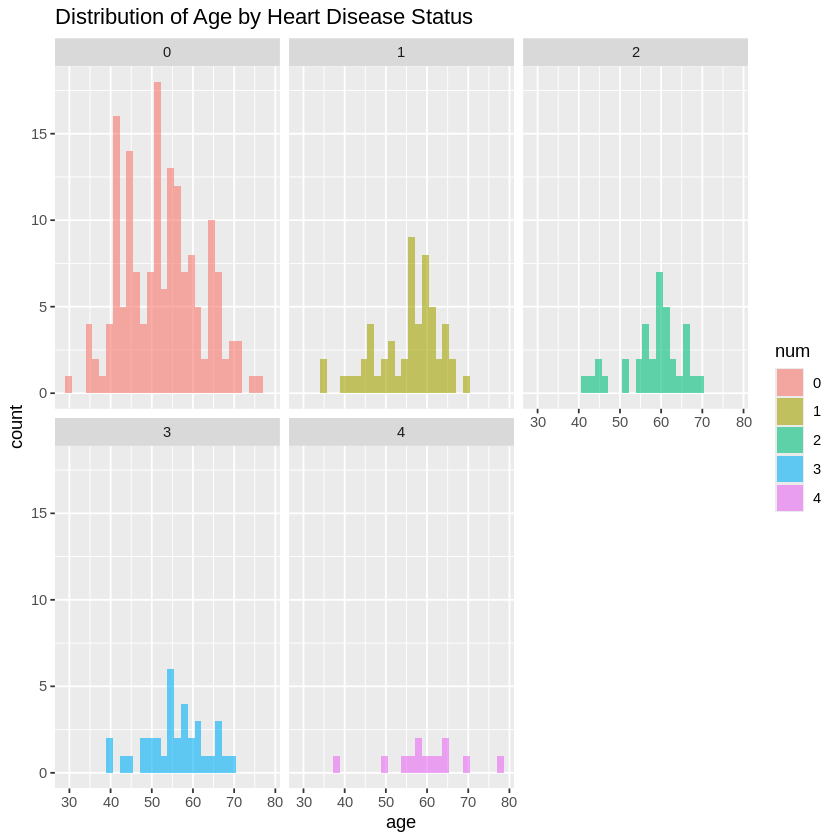

In [15]:
cleveland_plot <- ggplot(cleveland_data, aes(x = age, fill = num)) +
                  geom_histogram(bins = 30, alpha = 0.6) +
                  facet_wrap(~num) +
                  labs(title = "Distribution of Age by Heart Disease Status")
cleveland_plot

## Visualizing the Data

I visualized the age distribution among patients grouped by their heart disease status using a histogram. The plots are color-coded to represent different levels of heart disease severity as per the `num` variable, ranging from `0` (no heart disease) to `4` (most severe).

**Figure Explanation:**

- **No Heart Disease (num = 0)**: Displayed in pink, this histogram shows an even distribution across a wide age range with a peak in the late 50s to early 60s.
- **Mild Heart Disease (num = 1)**: In green, patients predominantly fall in the early 60s, indicating a shift towards older ages for those with mild heart disease.
- **Moderate Heart Disease (num = 2)**: The blue histogram peaks in the mid-50s, showing a relatively concentrated age distribution.
- **Moderately Severe Heart Disease (num = 3)**: Shown in teal, this group also centers around the early 60s.
- **Severe Heart Disease (num = 4)**: The purple histogram represents the most severe cases with a broad but small range of ages.

This visualization aids in understanding how age varies with the severity of heart disease, highlighting its significance as a potential predictor in my analysis.

## Methods:

**Data Analysis Approach:**
For this project, I will employ a classification approach using logistic regression, a common method for predicting binary outcomes such as the presence or absence of heart disease. The target variable for my model will be `num`, which I will convert into a binary format where `0` represents no heart disease and `1` (combining original classes 1 through 4) indicates the presence of heart disease. This simplification is based on the primary need to distinguish between the presence and absence of disease for initial screenings.

**Variables Used for Prediction:**
- **Age (`age`)**: As seen from the exploratory data analysis, age is a significant factor in heart disease prevalence. I will include age as a continuous variable.
- **Cholesterol (`chol`)**: High cholesterol is a well-established risk factor for heart disease. It will be included as a continuous variable to assess its predictive power.
- **Maximum Heart Rate (`thalach`)**: The maximum heart rate achieved during a stress test inversely correlates with heart disease risk. It will also be used as a continuous variable.

**Exclusion of Variables:**
Certain variables like `sex`, `restecg` (resting electrocardiographic results), and others might contain valuable information but are excluded in this initial model to maintain focus on the most interpretable and widely recognized risk factors. This decision also helps in reducing model complexity and potential overfitting.

**Model Validation:**
The dataset will be split into training and testing subsets, with approximately 70% of the data used for training and 30% reserved for testing the model. This split ensures that my model is trained on a large portion of the data while still leaving a substantial amount untouched for an unbiased evaluation of model performance.

**Visualization of Results:**
1. **ROC Curve**: Upon model completion, I will visualize the results using a Receiver Operating Characteristic (ROC) curve. This plot is crucial for evaluating the effectiveness of the logistic regression model at various classification thresholds, showing the trade-off between sensitivity and specificity.
2. **Coefficient Plot**: To interpret the impact of each predictor variable on the likelihood of predicting heart disease, I will use a coefficient plot from the logistic regression model. This will highlight which factors increase or decrease the probability of heart disease, providing insights into their relative importance.

By following these methods, the project will rigorously analyze how well age, cholesterol, and maximum heart rate can predict heart disease, thus contributing valuable insights into early detection efforts.